# 0.0. IMPORTS

In [14]:
import pandas as pd
import inflection
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.display import Image

## 0.1. Helper Functions

## 0.2. Loading data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge ( df_sales_raw , df_store_raw , how = 'left' , on='Store' )

# 1.0. DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
            'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new  = list( map( snakecase , cols_old ) )

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print( 'Number of rows: {}' .format(df1.shape[0]))
print( 'Number of columns: {}' .format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [5]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [8]:
df1['competition_distance'].max()

75860.0

In [6]:
#competition_distance   
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x ['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x ['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x ['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x ['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

## 1.6. Change Types

In [7]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical 

In [8]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [9]:
# Central Tendecy - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

In [10]:
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'desvio_padrao', 'skew', 'kurtosis']

In [23]:
m

,attributes,min,max,range,media,mediana,desvio_padrao,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


### 1.7.2 Categoriacal Attributes

In [11]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

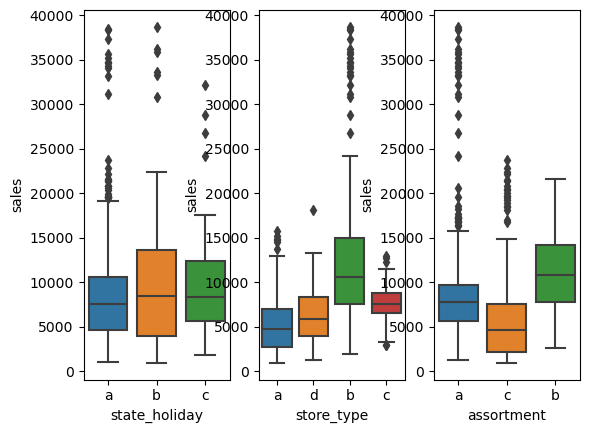

In [12]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1 , 3 , 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1 , 3 , 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1 , 3 , 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. FEAUTURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

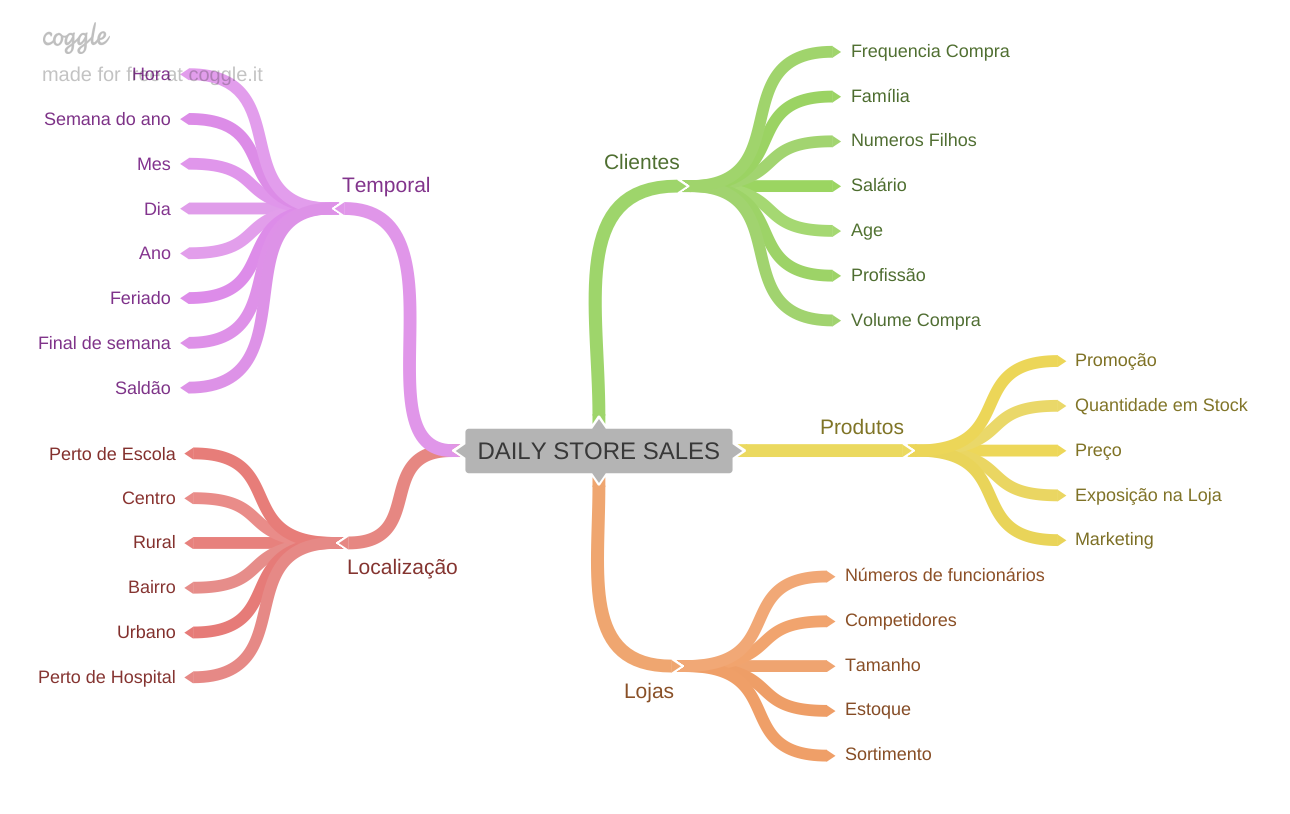

In [17]:
Image('imagem/mind_map_hypoteses.png')

## 2.2. Criação das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionário deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveria vender menos.


### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõem mais produtos em sua vitrine deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores nos produtos por mais tempo deveriam vender mais.

**5.** Lojas com promoções ativas há mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecultivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender mais.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas que abrem durante o natal deveriam vender mais.

**5.** Lojas deveriam vender mais ao longo dos anos.

**6.** Lojas deveriam vender mais no segundo semestre do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**8.** Lojas deveriam vender menos nos finais de semana.

**9.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveria vender menos.

**4.** Lojas com promoções ativas há mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecultivas deveriam vender mais.

**7.** Lojas que abrem durante o natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.weekofyear

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month= x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1' , '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


C:\Users\marce\AppData\Local\Temp\ipykernel_11816\3365450191.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df1['date'].dt.weekofyear


# 3.0. FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1. Filtragem da Linhas

In [23]:
df3 = df3[( df2['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Seleção das Colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)